In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.dates as mdates

import ochre_gym

import gymnasium as gym

from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
# print("--- DIAGNOSTIC START ---")

# env = ochre_gym.load(
#     "bldg0112631-up11",
#     override_equipment_controls={"HVAC Heating": ["Setpoint"]},
#     vectorize_actions=True,
#     vectorize_observations=False,
    
#     start_time="2018-01-01 00:00:00",
#     episode_duration="1 days",
#     time_res="00:30",
#     lookahead="12:00",            
    
#     dr_type="TOU",
#     dr_subfolder="denver",
#     tou_price_file="time_of_use_price.csv"
# )

# obs, info = env.reset()

# print("\n=== FULL OBSERVATION KEY LIST (with sample values) ===")
# for i, (k, v) in enumerate(sorted(obs.items())):
#     print(f"{i+1:02d}: {k:40s} -> {v}")
# print("======================================================")

# env.close()

In [3]:
# -------------------------------------------------------------
# Environment configuration
# -------------------------------------------------------------

ENV_NAME = "bldg0112631-up11"

# Base observation keys (current values only)
BASE_OBS_KEYS = [
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Energy Price ($)",
    "Hour of day",
]

def build_obs_keys_with_forecast():
    """
    Build OBS_KEYS.

    Note:
    OCHRE vectorizes observations in alphabetical order of the keys.
    We therefore sort BASE_OBS_KEYS here so that the positions in the
    vectorized obs match the indices we derive below. Future temperature
    and price features (next 12 hours) will be appended via a separate
    wrapper, not via OCHRE's built-in observation keys.
    """
    return sorted(BASE_OBS_KEYS)

# Observation keys selected from the OCHRE environment
OBS_KEYS = build_obs_keys_with_forecast()

# Indices for vectorized observations (alphabetical order matching OCHRE)
INDOOR_TEMP_IDX  = OBS_KEYS.index("Temperature - Indoor (C)")
OUTDOOR_TEMP_IDX = OBS_KEYS.index("Temperature - Outdoor (C)")
PRICE_IDX        = OBS_KEYS.index("Energy Price ($)")
HOUR_IDX         = OBS_KEYS.index("Hour of day")


def make_env(start_time: str, episode_duration: str):
    """
    Helper to create an OCHRE environment for a given start time and duration.
    The environment exposes a continuous heating setpoint action for SAC.
    """
    base_env = ochre_gym.load(
        ENV_NAME,
        override_equipment_controls={"HVAC Heating": ["Setpoint"]},
        vectorize_actions=True,
        vectorize_observations=True,
        override_ochre_observations_with_keys=OBS_KEYS,

        # Episode settings
        start_time=start_time,
        episode_duration=episode_duration,
        time_res="00:30",
        lookahead="12:00",  # still use 12h lookahead internally

        # Demand response configuration
        dr_type="TOU",
        dr_subfolder="denver",
        tou_price_file="time_of_use_price.csv",

        # Comfort constraints and reward scaling
        thermal_comfort_band_low=20,
        thermal_comfort_band_high=23,
        thermal_comfort_unit_penalty=0.0,
        reward_scale=0.1,

        # Logging options
        log_to_file=False,
        log_to_console=False,
    )
    return base_env

In [4]:
# -------------------------------------------------------------
# Varying thermal comfort band (User-defined Logic)
# -------------------------------------------------------------
def get_comfort_band(hour_of_day: float):
    """
    Returns (low, high) comfort band in °C based on the hour of day.

    - 19–23 °C for h in [18:00, 24:00) U [00:00, 09:00)
      (i.e., 09:00 itself is relaxed)
    - 17–26 °C for h in [09:00, 18:00)
    """
    h = float(hour_of_day) % 24.0

    # Night / early morning / boundary hours (occupied)
    if (h >= 18.0) or (h < 9.0):
        return 19.0, 23.0
    # Daytime (unoccupied / relaxed)
    else:
        return 17.0, 26.0


def is_occupied(hour_of_day: float) -> bool:
    """
    Returns True if the building is considered occupied.
    Occupied from 18:00–24:00 and 00:00–09:00 (excluding 09:00).
    """
    h = float(hour_of_day) % 24.0
    return (h >= 18.0) or (h < 9.0)


def get_preferred_temp(hour_of_day: float):
    """
    Returns the preferred indoor temperature (°C) if occupied,
    otherwise None. Preference is 21 °C during occupancy.
    """
    if is_occupied(hour_of_day):
        return 21.0
    return None


# -------------------------------------------------------------
# Wrapper to apply varying thermal comfort band to the reward
# -------------------------------------------------------------
class VariableComfortRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        comfort_unit_penalty: float = 0.0,
        reward_scale: float = 0.1,
        energy_cost_multiplier: float = 1.0,
        preferred_temp: float | None = 21.0,
        preferred_temp_weight: float = 0.0,  # set >0 to activate preference
    ):
        """
        env: base OCHRE env with thermal_comfort_unit_penalty=0.0 in its config
        comfort_unit_penalty: penalty per °C deviation from comfort band
        reward_scale: same scale factor used in the base env
        energy_cost_multiplier: factor to multiply the base energy reward by
        preferred_temp: target indoor temperature during occupancy (°C)
        preferred_temp_weight: weight for |T_in - preferred_temp| reward penalty
        """
        super().__init__(env)
        self.comfort_unit_penalty = comfort_unit_penalty
        self.reward_scale = reward_scale
        self.energy_cost_multiplier = energy_cost_multiplier
        self.preferred_temp = preferred_temp
        self.preferred_temp_weight = preferred_temp_weight

    def reset(self, **kwargs):
        # Base reset
        obs, info = self.env.reset(**kwargs)
        info = dict(info) if isinstance(info, dict) else {}

        # Mirror hour / price from obs into info
        obs_arr = np.asarray(obs).ravel()
        if obs_arr.size > HOUR_IDX:
            info["Hour of day"] = float(obs_arr[HOUR_IDX])
        if obs_arr.size > PRICE_IDX:
            info["Energy Price ($)"] = float(obs_arr[PRICE_IDX])

        # --- populate state-based comfort info at t = 0 ---

        # Hour-of-day and comfort band
        hour_of_day = self._hour_from_info(info, obs)
        comfort_low, comfort_high = get_comfort_band(hour_of_day)

        # Indoor temperature (prefer info, fallback to obs)
        if "Temperature - Indoor (C)" in info:
            indoor_temp = float(info["Temperature - Indoor (C)"])
        else:
            indoor_temp = (
                float(obs_arr[INDOOR_TEMP_IDX])
                if obs_arr.size > INDOOR_TEMP_IDX
                else np.nan
            )

        # Comfort violation
        if np.isnan(indoor_temp):
            comfort_violation = np.nan
        elif indoor_temp < comfort_low:
            comfort_violation = comfort_low - indoor_temp
        elif indoor_temp > comfort_high:
            comfort_violation = indoor_temp - comfort_high
        else:
            comfort_violation = 0.0

        # Occupancy + preferred temp
        occ = is_occupied(hour_of_day)

        info["hour_used_for_band"] = hour_of_day
        info["comfort_low"] = comfort_low
        info["comfort_high"] = comfort_high
        info["comfort_violation"] = comfort_violation
        info["occupied"] = occ
        info["preferred_temp"] = self.preferred_temp

        # NOTE: no reward fields here; they are undefined at reset.

        return obs, info

    # define hour purely from what RL sees (obs_1 / "Hour of day")
    def _hour_from_info(self, info, obs=None) -> float:
        # 1) Prefer observation vector (this is what RL uses)
        if obs is not None:
            obs_arr = np.asarray(obs).ravel()
            if obs_arr.size > HOUR_IDX:
                return float(obs_arr[HOUR_IDX])

        # 2) Fallback: "Hour of day" in info if present
        if isinstance(info, dict) and ("Hour of day" in info):
            return float(info["Hour of day"])

        # 3) Last resort
        return 0.0

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        info = dict(info) if isinstance(info, dict) else {}

        # Mirror hour / price from obs into info
        obs_arr = np.asarray(obs).ravel()
        if obs_arr.size > HOUR_IDX:
            info["Hour of day"] = float(obs_arr[HOUR_IDX])
        if obs_arr.size > PRICE_IDX:
            info["Energy Price ($)"] = float(obs_arr[PRICE_IDX])

        # 1) scale base energy reward
        scaled_energy_reward = reward * self.energy_cost_multiplier

        # 2) hour-of-day and comfort band (aligned with RL obs)
        hour_of_day = self._hour_from_info(info, obs)
        comfort_low, comfort_high = get_comfort_band(hour_of_day)

        # 3) indoor temperature
        if "Temperature - Indoor (C)" in info:
            indoor_temp = float(info["Temperature - Indoor (C)"])
        else:
            indoor_temp = (
                float(obs_arr[INDOOR_TEMP_IDX])
                if obs_arr.size > INDOOR_TEMP_IDX
                else np.nan
            )

        # 4) soft comfort-band violation
        if indoor_temp < comfort_low:
            comfort_violation = comfort_low - indoor_temp
        elif indoor_temp > comfort_high:
            comfort_violation = indoor_temp - comfort_high
        else:
            comfort_violation = 0.0

        comfort_penalty_reward = (
            self.reward_scale * self.comfort_unit_penalty * comfort_violation
        )

        # 5) preference reward for 21 °C during occupancy
        pref_penalty_reward = 0.0
        occ = is_occupied(hour_of_day)
        if (
            occ
            and self.preferred_temp is not None
            and self.preferred_temp_weight > 0.0
            and not np.isnan(indoor_temp)
        ):
            temp_error = abs(indoor_temp - self.preferred_temp)
            pref_penalty_reward = (
                self.reward_scale * self.preferred_temp_weight * temp_error
            )

        # 6) total reward
        new_reward = (
            scaled_energy_reward
            - comfort_penalty_reward
            - pref_penalty_reward
        )

        # logging
        info["hour_used_for_band"] = hour_of_day
        info["comfort_low"] = comfort_low
        info["comfort_high"] = comfort_high
        info["comfort_violation"] = comfort_violation
        info["original_energy_reward"] = reward
        info["scaled_energy_reward"] = scaled_energy_reward
        info["comfort_penalty_reward"] = comfort_penalty_reward
        info["pref_penalty_reward"] = pref_penalty_reward
        info["custom_reward"] = new_reward
        info["occupied"] = occ
        info["preferred_temp"] = self.preferred_temp

        # signed components for per-episode accounting
        info["r_energy"] = scaled_energy_reward
        info["r_comfort"] = -comfort_penalty_reward
        info["r_pref"] = -pref_penalty_reward

        return obs, new_reward, terminated, truncated, info


In [5]:
# -------------------------------------------------------------
# Wrapper to append 12-hour forecasts (T_out, price) to obs
# -------------------------------------------------------------
class ForecastObsWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        start_time: str,
        episode_duration: str,
        horizon_hours: float = 12.0,
        time_res_minutes: int = 30,
    ):
        """
        Wraps an OCHRE env and augments the observation with future
        outdoor temperature and energy prices over a lookahead horizon.

        The base env exposes the 4 core obs defined in OBS_KEYS, which are
        vectorized in alphabetical order by OCHRE; semantics should always
        be accessed via the indices PRICE_IDX, HOUR_IDX, INDOOR_TEMP_IDX,
        and OUTDOOR_TEMP_IDX rather than assuming a fixed position.

        This wrapper appends:
        [T_out(t+1), ..., T_out(t+H),
         price(t+1), ..., price(t+H)]
        where H = horizon_hours / time_res_minutes * 60.
        """
        super().__init__(env)
        self.start_time = start_time
        self.episode_duration = episode_duration
        self.horizon_hours = horizon_hours
        self.time_res_minutes = time_res_minutes
        self.horizon_steps = int(horizon_hours * 60 / time_res_minutes)

        # Internal step counter within the episode
        self._current_step = 0

        # Precompute outdoor temperature and price for this episode window
        self._build_forecast_index()

        # Extend observation space: original dims + 2 * horizon_steps
        orig_space = env.observation_space
        orig_low = np.asarray(orig_space.low, dtype=np.float32).ravel()
        orig_high = np.asarray(orig_space.high, dtype=np.float32).ravel()

        extra_dim = 2 * self.horizon_steps  # future temps + future prices
        extra_low = np.full(extra_dim, -np.inf, dtype=np.float32)
        extra_high = np.full(extra_dim, np.inf, dtype=np.float32)

        self.observation_space = gym.spaces.Box(
            low=np.concatenate([orig_low, extra_low]),
            high=np.concatenate([orig_high, extra_high]),
            dtype=np.float32,
        )

    def _build_forecast_index(self):
        """
        Build a mapping from step index -> {T_out, price} for the whole
        episode window by running a temporary OCHRE env once.
        """
        tmp_env = ochre_gym.load(
            ENV_NAME,
            override_equipment_controls={"HVAC Heating": ["Setpoint"]},
            vectorize_actions=True,
            vectorize_observations=True,
            override_ochre_observations_with_keys=OBS_KEYS,

            start_time=self.start_time,
            episode_duration=self.episode_duration,
            time_res="00:30",
            lookahead="12:00",

            dr_type="TOU",
            dr_subfolder="denver",
            tou_price_file="time_of_use_price.csv",

            thermal_comfort_band_low=20,
            thermal_comfort_band_high=23,
            thermal_comfort_unit_penalty=0.0,
            reward_scale=0.1,

            log_to_file=False,
            log_to_console=False,
        )

        obs, info = tmp_env.reset()
        self._forecast_data = {}
        step_idx = 0

        while True:
            obs_vec = np.asarray(obs).ravel()

            # Prefer info keys; fall back to obs vector if needed
            if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
                t_out = info["Temperature - Outdoor (C)"]
            else:
                t_out = obs_vec[OUTDOOR_TEMP_IDX]

            if isinstance(info, dict) and ("Energy Price ($)" in info):
                price = info["Energy Price ($)"]
            else:
                price = obs_vec[PRICE_IDX]

            self._forecast_data[step_idx] = {
                "Temperature - Outdoor (C)": float(t_out),
                "Energy Price ($)": float(price),
            }

            # Any reasonable fixed action is fine; T_out and price don't depend on action
            action = np.array([21.0], dtype=np.float32)
            obs, r, terminated, truncated, info = tmp_env.step(action)
            step_idx += 1
            if terminated or truncated:
                break

        tmp_env.close()
        self._episode_length = step_idx  # total number of steps in the episode

    def _augment_observation(self, obs, step_idx, info):
        """
        Concatenate current obs with future T_out and price over the horizon.
        """
        obs_vec = np.asarray(obs).ravel()

        future_temps = []
        future_prices = []

        for k in range(1, self.horizon_steps + 1):
            idx = step_idx + k
            if idx >= self._episode_length:
                # Beyond last step: repeat last known values
                last = self._forecast_data[self._episode_length - 1]
                temp_k = last["Temperature - Outdoor (C)"]
                price_k = last["Energy Price ($)"]
            else:
                data_k = self._forecast_data[idx]
                temp_k = data_k["Temperature - Outdoor (C)"]
                price_k = data_k["Energy Price ($)"]

            future_temps.append(temp_k)
            future_prices.append(price_k)

        extra = np.asarray(future_temps + future_prices, dtype=obs_vec.dtype)
        return np.concatenate([obs_vec, extra], axis=0)

    def reset(self, **kwargs):
        self._current_step = 0
        obs, info = self.env.reset(**kwargs)
        obs_aug = self._augment_observation(obs, self._current_step, info)
        return obs_aug, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self._current_step += 1
        obs_aug = self._augment_observation(obs, self._current_step, info)
        return obs_aug, reward, terminated, truncated, info

In [6]:
# -------------------------------------------------------------
# Sanity check: verify comfort band + key observations
# -------------------------------------------------------------
# Ensure start times match
START_TIME_STR = "2018-02-01 00:00:00"

debug_env = VariableComfortRewardWrapper(
    make_env(START_TIME_STR, "1 days"),
    comfort_unit_penalty=50.0,
    reward_scale=0.1,
    energy_cost_multiplier=12.0,
    preferred_temp=21.0,
    preferred_temp_weight=5.0,
)

obs, info = debug_env.reset()
rows = []

start_ts = pd.Timestamp(START_TIME_STR)

# 48 steps = 24 hours at 30 min/step
for t in range(50):
    # Datetime from info if present, otherwise reconstruct from start time
    dt_info = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt_info is None:
        dt = start_ts + pd.Timedelta(minutes=30 * t)
    else:
        dt = pd.to_datetime(dt_info)

    # Flatten observation vector
    obs_arr = np.asarray(obs).ravel()

    # Semantic obs via indices (for clarity)
    price_obs = obs_arr[PRICE_IDX] if obs_arr.size > PRICE_IDX else np.nan
    hour_obs  = obs_arr[HOUR_IDX]  if obs_arr.size > HOUR_IDX  else np.nan
    tin_obs   = obs_arr[INDOOR_TEMP_IDX] if obs_arr.size > INDOOR_TEMP_IDX else np.nan
    tout_obs  = obs_arr[OUTDOOR_TEMP_IDX] if obs_arr.size > OUTDOOR_TEMP_IDX else np.nan

    row = {
        "Datetime": dt,

        # What the wrapper logged (if present)
        "hour_used_for_band": info.get("hour_used_for_band", np.nan),
        "comfort_low_info": info.get("comfort_low", np.nan),
        "comfort_high_info": info.get("comfort_high", np.nan),
        "comfort_violation_info": info.get("comfort_violation", np.nan),
        "original_energy_reward": info.get("original_energy_reward", np.nan),
        "scaled_energy_reward": info.get("scaled_energy_reward", np.nan),
        "comfort_penalty_reward": info.get("comfort_penalty_reward", np.nan),
        "pref_penalty_reward": info.get("pref_penalty_reward", np.nan),
        "custom_reward": info.get("custom_reward", np.nan),
        "r_energy": info.get("r_energy", np.nan),
        "r_comfort": info.get("r_comfort", np.nan),
        "r_pref": info.get("r_pref", np.nan),
        "occupied": info.get("occupied", np.nan),
        "preferred_temp": info.get("preferred_temp", np.nan),

        # Observations from info (trusted physical variables)
        "indoor_temp_info": info.get("Temperature - Indoor (C)", np.nan),
        "outdoor_temp_info": info.get("Temperature - Outdoor (C)", np.nan),
        "price_info": info.get("Energy Price ($)", np.nan),
        "hour_info": info.get("Hour of day", np.nan),

        # Semantic obs from vector
        "price_obs": price_obs,
        "hour_obs": hour_obs,
        "T_in_obs": tin_obs,
        "T_out_obs": tout_obs,
    }
    rows.append(row)

    # Fixed action (e.g., 21°C setpoint) – only for advancing the env
    action = np.array([21.0], dtype=np.float32)
    obs, r, terminated, truncated, info = debug_env.step(action)
    if terminated or truncated:
        break

debug_env.close()

debug_df = pd.DataFrame(rows)

# ---- Minimal formatting change for Datetime column ----
if not debug_df.empty:
    # Get date from first row
    first_date = pd.to_datetime(debug_df["Datetime"].iloc[0]).date()
    time_col_name = f"Datetime ({first_date})"

    # Convert to time-only strings
    debug_df[time_col_name] = pd.to_datetime(debug_df["Datetime"]).dt.strftime("%H:%M:%S")

    # Drop original Datetime column
    debug_df = debug_df.drop(columns=["Datetime"])

    # ---- Minimal change: show obs_* mapping in column headers ----
    debug_df = debug_df.rename(
        columns={
            "price_obs": "price_obs (obs_0)",
            "hour_obs": "hour_obs (obs_1)",
            "T_in_obs": "T_in_obs (obs_2)",
            "T_out_obs": "T_out_obs (obs_3)",
        }
    )

    # 2a) Reward-related variables (energy / comfort / preference / total)
    reward_cols = [
        time_col_name,
        "scaled_energy_reward",      # energy reward
        "comfort_penalty_reward",    # comfort penalty reward
        "pref_penalty_reward",       # preference penalty reward
        "custom_reward",             # final reward
        "r_energy",
        "r_comfort",
        "r_pref",
    ]
    reward_df = debug_df[reward_cols].copy()

    # 2b) Other info-based variables (env + wrapper, physical vars)
    info_cols = [
        time_col_name,
        "hour_used_for_band",
        "comfort_low_info",
        "comfort_high_info",
        "comfort_violation_info",
        "occupied",
        "preferred_temp",
        "indoor_temp_info",
        "outdoor_temp_info",
        "price_info",
        "hour_info",
    ]
    info_df = debug_df[info_cols].copy()

    # 3) Observation vector (what RL sees)
    obs_cols = [
        time_col_name,
        "price_obs (obs_0)",
        "hour_obs (obs_1)",
        "T_in_obs (obs_2)",
        "T_out_obs (obs_3)",
    ]
    obs_df = debug_df[obs_cols].copy()

    print("=== Reward Components (Energy / Comfort / Preference / Total) ===")
    display(reward_df)

    print("=== Other Info / Physical Vars ===")
    display(info_df)

    print("=== Observation Vector (RL Inputs) ===")
    display(obs_df)


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


=== Reward Components (Energy / Comfort / Preference / Total) ===


,Datetime (2018-02-01),scaled_energy_reward,comfort_penalty_reward,pref_penalty_reward,custom_reward,r_energy,r_comfort,r_pref
0,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00:30:00,-0.153322,0.0,0.039011,-0.192333,-0.153322,-0.0,-0.039011
2,01:00:00,-0.141439,0.0,0.044860,-0.186299,-0.141439,-0.0,-0.044860
3,01:30:00,-0.139660,0.0,0.046800,-0.186460,-0.139660,-0.0,-0.046800
4,02:00:00,-0.141501,0.0,0.047453,-0.188954,-0.141501,-0.0,-0.047453
5,02:30:00,-0.141228,0.0,0.047484,-0.188712,-0.141228,-0.0,-0.047484
6,03:00:00,-0.143876,0.0,0.047576,-0.191452,-0.143876,-0.0,-0.047576
7,03:30:00,-0.143914,0.0,0.047448,-0.191363,-0.143914,-0.0,-0.047448
8,04:00:00,-0.149958,0.0,0.047487,-0.197445,-0.149958,-0.0,-0.047487
9,04:30:00,-0.150286,0.0,0.047342,-0.197627,-0.150286,-0.0,-0.047342


=== Other Info / Physical Vars ===


,Datetime (2018-02-01),hour_used_for_band,comfort_low_info,comfort_high_info,comfort_violation_info,occupied,preferred_temp,indoor_temp_info,outdoor_temp_info,price_info,hour_info
0,00:00:00,0.0,19.0,23.0,0.0,True,21.0,20.707196,-9.4,0.07,0.0
1,00:30:00,0.0,19.0,23.0,0.0,True,21.0,21.078022,-6.1,0.07,0.0
2,01:00:00,0.0,19.0,23.0,0.0,True,21.0,21.089720,-6.5,0.07,0.0
3,01:30:00,1.0,19.0,23.0,0.0,True,21.0,21.093600,-6.5,0.07,1.0
4,02:00:00,1.0,19.0,23.0,0.0,True,21.0,21.094906,-6.9,0.07,1.0
5,02:30:00,2.0,19.0,23.0,0.0,True,21.0,21.094969,-6.9,0.07,2.0
6,03:00:00,2.0,19.0,23.0,0.0,True,21.0,21.095151,-7.3,0.07,2.0
7,03:30:00,3.0,19.0,23.0,0.0,True,21.0,21.094897,-7.3,0.07,3.0
8,04:00:00,3.0,19.0,23.0,0.0,True,21.0,21.094974,-7.8,0.07,3.0
9,04:30:00,4.0,19.0,23.0,0.0,True,21.0,21.094684,-7.8,0.07,4.0


=== Observation Vector (RL Inputs) ===


,Datetime (2018-02-01),price_obs (obs_0),hour_obs (obs_1),T_in_obs (obs_2),T_out_obs (obs_3)
0,00:00:00,0.07,0.0,20.707196,-9.4
1,00:30:00,0.07,0.0,21.078022,-6.1
2,01:00:00,0.07,0.0,21.089720,-6.5
3,01:30:00,0.07,1.0,21.093600,-6.5
4,02:00:00,0.07,1.0,21.094906,-6.9
5,02:30:00,0.07,2.0,21.094969,-6.9
6,03:00:00,0.07,2.0,21.095151,-7.3
7,03:30:00,0.07,3.0,21.094897,-7.3
8,04:00:00,0.07,3.0,21.094974,-7.8
9,04:30:00,0.07,4.0,21.094684,-7.8


In [7]:
# -------------------------------------------------------------
# Full augmented observation table (all 52 features)
# -------------------------------------------------------------
HORIZON_HOURS = 12.0
TIME_RES_MIN = 30
H = int(HORIZON_HOURS * 60 / TIME_RES_MIN)   # 12h / 30min = 24 steps
BASE_DIM = len(OBS_KEYS)                     # 4 base obs

EXTRA_TEMP_START = BASE_DIM                  # T_out(t+1..t+H)
EXTRA_PRICE_START = BASE_DIM + H             # price(t+1..t+H)

# Build wrapped env: base -> comfort reward -> forecast obs
full_env = ForecastObsWrapper(
    VariableComfortRewardWrapper(
        make_env("2018-01-06 00:00:00", "1 days"),
        comfort_unit_penalty=50.0,
        reward_scale=0.1,
        energy_cost_multiplier=12.0,
        preferred_temp=21.0,
        preferred_temp_weight=5.0,
    ),
    start_time="2018-01-06 00:00:00",
    episode_duration="1 days",
    horizon_hours=HORIZON_HOURS,
    time_res_minutes=TIME_RES_MIN,
)

obs, info = full_env.reset()
rows = []

start_ts = pd.Timestamp("2018-01-06 00:00:00")

# 48 steps = 24 hours at 30 min/step
for t in range(48):
    # Datetime from info if present, otherwise reconstruct from start time
    dt_info = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt_info is None:
        dt = start_ts + pd.Timedelta(minutes=TIME_RES_MIN * t)
    else:
        dt = pd.to_datetime(dt_info)

    obs_arr = np.asarray(obs).ravel()

    row = {
        "step": t,
        "Datetime": dt,
        "obs_dim": obs_arr.size,
        # base obs via semantic indices
        "price_now":  obs_arr[PRICE_IDX],
        "hour_now":   obs_arr[HOUR_IDX],
        "T_in_now":   obs_arr[INDOOR_TEMP_IDX],
        "T_out_now":  obs_arr[OUTDOOR_TEMP_IDX],

        # # reward components from wrapper (if present)
        # "scaled_energy_reward": info.get("scaled_energy_reward", np.nan),
        # "comfort_penalty_reward": info.get("comfort_penalty_reward", np.nan),
        # "pref_penalty_reward": info.get("pref_penalty_reward", np.nan),
        # "custom_reward": info.get("custom_reward", np.nan),
        # "r_energy": info.get("r_energy", np.nan),
        # "r_comfort": info.get("r_comfort", np.nan),
        # "r_pref": info.get("r_pref", np.nan),
    }

    # All future outdoor temperatures
    for k in range(1, H + 1):
        row[f"T_out+{k}"] = obs_arr[EXTRA_TEMP_START + k - 1]

    # All future prices
    for k in range(1, H + 1):
        row[f"price+{k}"] = obs_arr[EXTRA_PRICE_START + k - 1]

    rows.append(row)

    action = np.array([21.0], dtype=np.float32)  # fixed setpoint just to advance
    obs, r, terminated, truncated, info = full_env.step(action)
    if terminated or truncated:
        break

full_env.close()

full_obs_df = pd.DataFrame(rows)

# Optional: pretty time-only column like other debug tables
if not full_obs_df.empty:
    first_date = pd.to_datetime(full_obs_df["Datetime"].iloc[0]).date()
    time_col_name = f"Datetime ({first_date})"
    full_obs_df[time_col_name] = pd.to_datetime(full_obs_df["Datetime"]).dt.strftime("%H:%M:%S")
    full_obs_df = full_obs_df.drop(columns=["Datetime"])
    # Put time + step first
    cols = [time_col_name, "step"] + [c for c in full_obs_df.columns if c not in [time_col_name, "step"]]
    full_obs_df = full_obs_df[cols]

full_obs_df


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


,Datetime (2018-01-06),step,obs_dim,price_now,hour_now,T_in_now,T_out_now,T_out+1,T_out+2,T_out+3,...,price+15,price+16,price+17,price+18,price+19,price+20,price+21,price+22,price+23,price+24
0,00:00:00,0,52,0.07,0.0,20.710840,-8.9,0.0,0.0,0.0,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
1,00:30:00,1,52,0.07,0.0,21.088044,0.0,0.0,0.0,1.1,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
2,01:00:00,2,52,0.07,0.0,21.093112,0.0,0.0,1.1,1.1,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
3,01:30:00,3,52,0.07,1.0,21.094446,0.0,1.1,1.1,0.6,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
4,02:00:00,4,52,0.07,1.0,21.095017,1.1,1.1,0.6,0.6,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
5,02:30:00,5,52,0.07,2.0,21.094848,1.1,0.6,0.6,0.0,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
6,03:00:00,6,52,0.07,2.0,21.094978,0.6,0.6,0.0,0.0,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
7,03:30:00,7,52,0.07,3.0,21.094707,0.6,0.0,0.0,-0.6,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
8,04:00:00,8,52,0.07,3.0,21.094798,0.0,0.0,-0.6,-0.6,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
9,04:30:00,9,52,0.07,4.0,21.094552,0.0,-0.6,-0.6,0.0,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07


In [8]:
# -------------------------------------------------------------
# Monitor-wrapped training env (31-day episode starting Jan 1)
#   Stack: OCHRE -> ComfortReward -> ForecastObs -> Monitor
# -------------------------------------------------------------
def make_train_env():
    start_time = "2018-01-01 00:00:00"
    episode_duration = "31 days"  # Train on full month episodes

    base = make_env(start_time, episode_duration)

    # Apply the varying comfort-band reward wrapper
    base = VariableComfortRewardWrapper(
        base,
        comfort_unit_penalty=50.0,
        reward_scale=0.1,
        energy_cost_multiplier=12.0,
        preferred_temp=21.0,
        preferred_temp_weight=5.0,
    )

    # Append 12-hour forecasts of T_out and price to the observation
    base = ForecastObsWrapper(
        base,
        start_time=start_time,
        episode_duration=episode_duration,
        horizon_hours=12.0,
        time_res_minutes=30,
    )

    return Monitor(base)

train_env = DummyVecEnv([make_train_env])


# -------------------------------------------------------------
# Callback to record episode returns during training
# -------------------------------------------------------------
class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.ep_returns: list[float] = []
        self.ep_returns_energy: list[float] = []
        self.ep_returns_comfort: list[float] = []
        self.ep_returns_pref: list[float] = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        if not infos:
            return True

        # lazy init running sums per env
        if not hasattr(self, "_run_energy"):
            n_envs = len(infos)
            self._run_energy = np.zeros(n_envs, dtype=float)
            self._run_comfort = np.zeros(n_envs, dtype=float)
            self._run_pref = np.zeros(n_envs, dtype=float)

        for i, info in enumerate(infos):
            self._run_energy[i] += info.get("r_energy", 0.0)
            self._run_comfort[i] += info.get("r_comfort", 0.0)
            self._run_pref[i] += info.get("r_pref", 0.0)

            if "episode" in info:
                # total reward for that finished episode
                self.ep_returns.append(info["episode"]["r"])
                # component-wise episode returns
                self.ep_returns_energy.append(self._run_energy[i])
                self.ep_returns_comfort.append(self._run_comfort[i])
                self.ep_returns_pref.append(self._run_pref[i])

                # reset running sums for that env
                self._run_energy[i] = 0.0
                self._run_comfort[i] = 0.0
                self._run_pref[i] = 0.0

        return True


# -------------------------------------------------------------
# SAC model definition
# -------------------------------------------------------------
sac_model = SAC(
    "MlpPolicy",
    train_env,
    verbose=2,
    learning_rate=3e-4,
    gamma=0.99,
    buffer_size=50_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",
)

# -------------------------------------------------------------
# Train SAC and log episode returns
# -------------------------------------------------------------
callback = EpisodeRewardCallback()

sac_model.learn(
    total_timesteps=150_000,
    log_interval=10,
    callback=callback,
)

ep_returns_sac = np.asarray(callback.ep_returns, dtype=float)
ep_energy_sac = np.asarray(callback.ep_returns_energy, dtype=float)
ep_comfort_sac = np.asarray(callback.ep_returns_comfort, dtype=float)
ep_pref_sac = np.asarray(callback.ep_returns_pref, dtype=float)

print(f"Recorded {len(ep_returns_sac)} finished episodes.")


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.49e+03  |
|    ep_rew_mean     | -2.33e+03 |
| time/              |           |
|    episodes        | 10        |
|    fps             | 32        |
|    time_elapsed    | 462       |
|    total_timesteps | 14880     |
| train/             |           |
|    actor_loss      | 182       |
|    critic_loss     | 13.1      |
|    ent_coef        | 0.614     |
|    ent_coef_loss   | -0.0148   |
|    learning_rate   | 0.0003    |
|    n_updates       | 14779     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.49e+03  |
|    ep_rew_mean     | -1.52e+03 |
| time/              |           |
|    episodes        | 20        |
|    fps             | 16        |
|    time_elapsed    | 1772      |
|    total_timesteps | 29760     |
| train/             |           |
|    actor_loss      | 169       |
|  

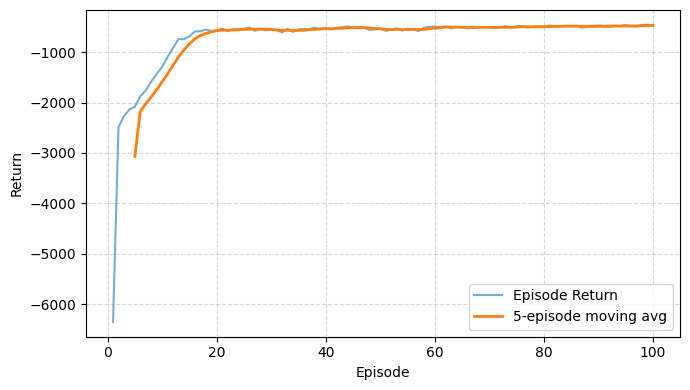

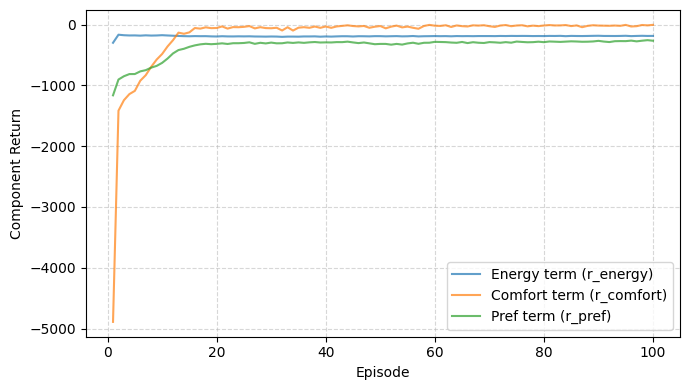

In [9]:
# -------------------------------------------------------------
# Plot: evolution of episode returns during training
# -------------------------------------------------------------
if len(ep_returns_sac) > 0:
    episodes = np.arange(1, len(ep_returns_sac) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(episodes, ep_returns_sac, label="Episode Return", alpha=0.6)

    # moving average
    window = 5
    if len(ep_returns_sac) >= window:
        ma = np.convolve(ep_returns_sac, np.ones(window) / window, mode="valid")
        plt.plot(
            np.arange(window, len(ep_returns_sac) + 1),
            ma,
            label=f"{window}-episode moving avg",
            linewidth=2,
        )

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # Plot: decomposition of episode returns (energy / comfort / pref)
    # ---------------------------------------------------------
    if "ep_energy_sac" in globals() and len(ep_energy_sac) == len(ep_returns_sac):
        plt.figure(figsize=(7, 4))
        plt.plot(episodes, ep_energy_sac,   label="Energy term (r_energy)",   alpha=0.7)
        plt.plot(episodes, ep_comfort_sac, label="Comfort term (r_comfort)", alpha=0.7)
        plt.plot(episodes, ep_pref_sac,    label="Pref term (r_pref)",       alpha=0.7)

        plt.xlabel("Episode")
        plt.ylabel("Component Return")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No episode returns were logged.")


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Running RL Agent...
Running Baseline...


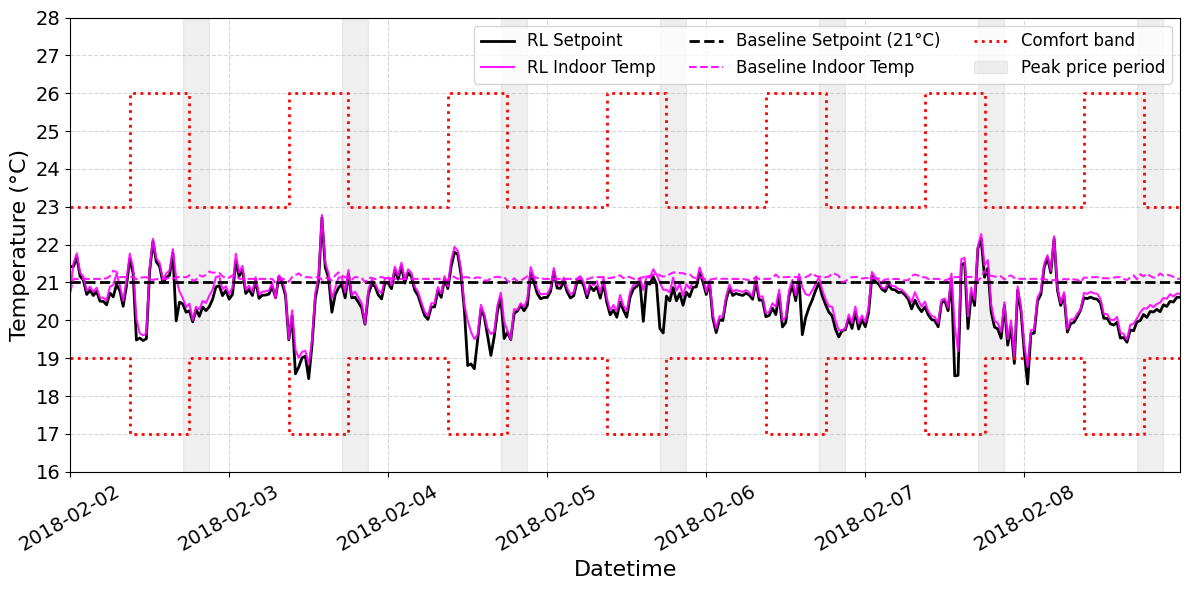

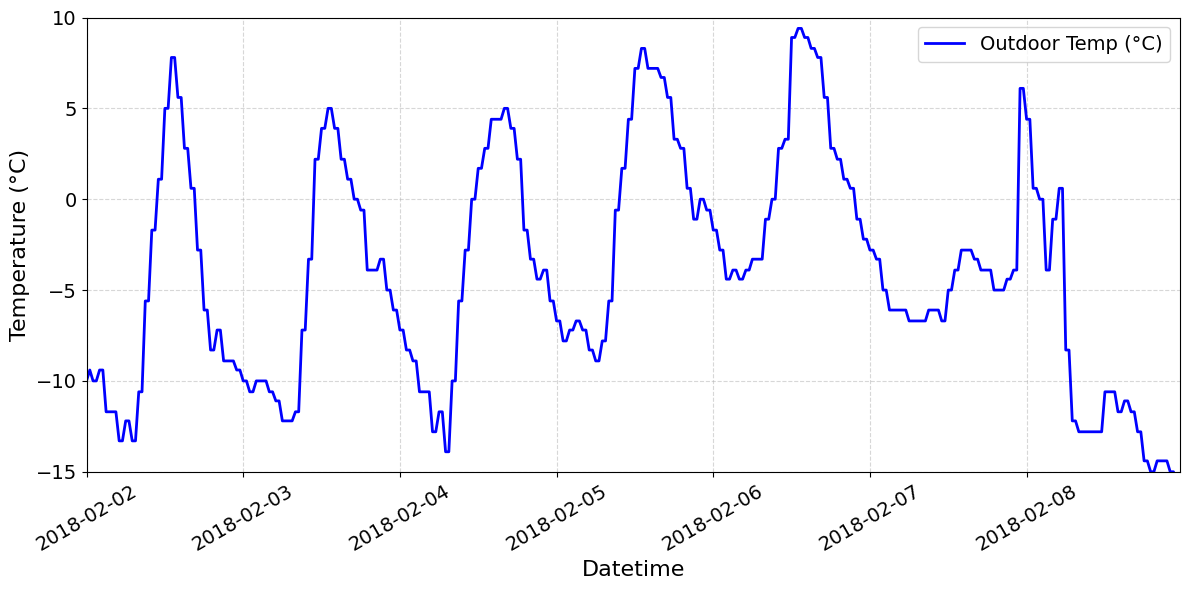

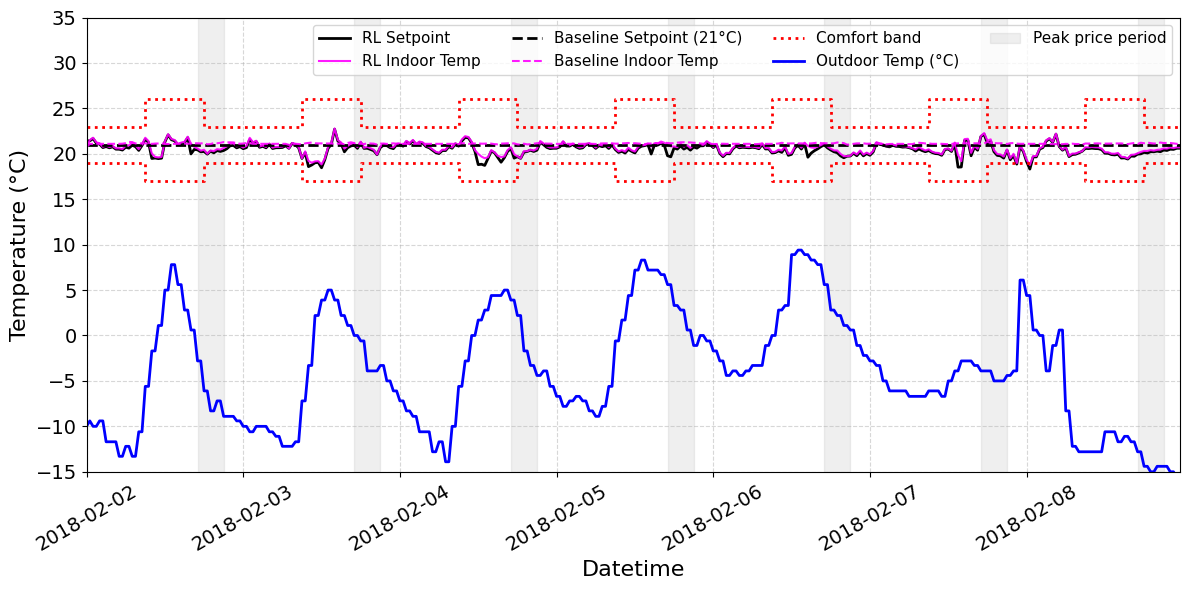

In [43]:
# ===========================
# Helpers
# ===========================
def is_occupied(hour_of_day: float) -> bool:
    """Restoring function to fix TypeError in environment wrapper."""
    h = float(hour_of_day) % 24.0
    return (h >= 18.0) or (h < 9.0)

def safe_datetime(info, t, start="2018-02-01", minutes=30):
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt

def extract_indoor_temp(obs, info):
    # Prefer info dict (ground truth)
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    # Fallback: Index 2 matches sorted OBS_KEYS
    obs = np.asarray(obs).ravel()
    return float(obs[2]) if obs.size >= 3 else np.nan

def extract_outdoor_temp(obs, info):
    # Prefer info dict (ground truth)
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    # Fallback: Index 3 matches sorted OBS_KEYS
    obs = np.asarray(obs).ravel()
    return float(obs[3]) if obs.size >= 4 else np.nan

def extract_obs_components(obs):
    """
    obs[0] = price_now
    obs[1] = hour_now
    obs[2] = T_in_now
    obs[3] = T_out_now
    """
    obs = np.asarray(obs).ravel()
    price = float(obs[0]) if obs.size >= 1 else np.nan
    hour  = float(obs[1]) if obs.size >= 2 else np.nan
    tin   = float(obs[2]) if obs.size >= 3 else np.nan
    tout  = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour

def compute_comfort_bands_from_hour(hours):
    """
    Compute comfort bands based on Ochre's hour observation,
    matching the is_occupied() logic exactly.
    """
    h = np.asarray(hours, dtype=float) % 24.0
    night_mask = (h >= 18.0) | (h < 9.0)
    lows  = np.where(night_mask, 19.0, 17.0)
    highs = np.where(night_mask, 23.0, 26.0)
    return lows, highs


# ===========================
# Baseline Controller
# ===========================
class RealisticThermostat:
    def __init__(self, setpoint=21):
        self.setpoint = np.array([setpoint], dtype=np.float32)

    def predict(self, obs, deterministic=True):
        return self.setpoint, None

# ===========================
# Evaluation Function
# ===========================
def evaluate_policy_with_actions(env, model, max_steps=2000, fallback_start="2018-02-01 00:00:00"):
    data = []
    obs, info = env.reset()

    # ---- NEW: record initial pre-step state at 00:00 ----
    tin0, tout0, price0, hour0 = extract_obs_components(obs)
    data.append({
        "Datetime": safe_datetime(info, 0, start=fallback_start),  # <-- minimal fix
        "Setpoint_RL": np.nan,  # no action applied yet
        "IndoorTemp_RL": extract_indoor_temp(obs, info),
        "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
        "Tout": tout0,
        "Price": price0,
        "Hour": hour0,
    })
    # -----------------------------------------------------

    for t in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0:
            raise RuntimeError("Empty action from model.")
        sp = float(action[0])

        obs, r, terminated, truncated, info = env.step(action)
        tin, tout, price, hour = extract_obs_components(obs)

        data.append({
            # use t+1 so fallback time is 00:30, 01:00, ... after the 00:00 row
            "Datetime": safe_datetime(info, t + 1, start=fallback_start),  # <-- minimal fix
            "Setpoint_RL": sp,
            "IndoorTemp_RL": extract_indoor_temp(obs, info),
            "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
            "Tout": tout,
            "Price": price,
            "Hour": hour,
        })

        if terminated or truncated:
            break

        df = pd.DataFrame(data)

    if len(df) >= 2 and np.isnan(df.loc[0, "Setpoint_RL"]):
        df.loc[0, "Setpoint_RL"] = df.loc[1, "Setpoint_RL"]

    return df


# ===========================
# Evaluation Env (UPDATED CONFIG)
# ===========================
def make_eval_env(
    start_time: str = "2018-02-02 00:00:00",
    episode_duration: str = "07 days",
):
    """Create an evaluation env for a given start time and episode duration."""
    base = make_env(start_time, episode_duration)
    base = VariableComfortRewardWrapper(
        base,
        comfort_unit_penalty=50.0,
        reward_scale=0.1,
        energy_cost_multiplier=12.0,
        preferred_temp=21.0,
        preferred_temp_weight=5.0,
    )
    base = ForecastObsWrapper(
        base,
        start_time=start_time,
        episode_duration=episode_duration,
        horizon_hours=12.0,
        time_res_minutes=30,
    )
    return base

# Default: 7-day evaluation window
EVAL_START_TIME = "2018-02-02 00:00:00"  # <-- minimal: single source of truth for fallback x-axis
env_feb = make_eval_env(start_time=EVAL_START_TIME, episode_duration="07 days")

# ===========================
# Run Simulations
# ===========================
print("Running RL Agent...")
env_feb.reset()
rl_df = evaluate_policy_with_actions(env_feb, sac_model, fallback_start=EVAL_START_TIME)

print("Running Baseline...")
env_feb.reset()
baseline_model = RealisticThermostat(setpoint=21)
base_df = evaluate_policy_with_actions(env_feb, baseline_model, fallback_start=EVAL_START_TIME)

# Compute time-varying comfort bands based on Datetime
comfort_low_series, comfort_high_series = compute_comfort_bands_from_hour(
    rl_df["Hour"]
)

# ===========================
# Figure 1: Indoor Temperature Comparison
# ===========================
plt.figure(figsize=(12, 6))

# RL Plots
plt.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
plt.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

# Baseline Plots
plt.plot(base_df["Datetime"], base_df["Setpoint_RL"], color="black", linestyle="--", linewidth=2, label="Baseline Setpoint (21°C)")
plt.plot(base_df["Datetime"], base_df["IndoorTemp_RL"], color="magenta", linestyle="--", alpha=0.9, linewidth=1.5, label="Baseline Indoor Temp")

# Comfort Bands (STEP PLOTS)
plt.step(
    rl_df["Datetime"],
    comfort_low_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
    label="Comfort band",
)
plt.step(
    rl_df["Datetime"],
    comfort_high_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
)

# Highlight peak price hours (17:00–21:00) as a grey region
_dt_series = pd.to_datetime(rl_df["Datetime"])
_hours_peak = _dt_series.dt.hour + _dt_series.dt.minute / 60.0
_peak_mask = (_hours_peak >= 17.0) & (_hours_peak < 21.0)
_dt_values_peak = _dt_series.to_numpy()
_peak_values = _peak_mask.to_numpy()

_in_peak = False
_peak_start = None
_added_peak_legend = False

for _dt, _peak in zip(_dt_values_peak, _peak_values):
    if _peak and not _in_peak:
        _in_peak = True
        _peak_start = _dt
    elif not _peak and _in_peak:
        if not _added_peak_legend:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0, label="Peak price period")
            _added_peak_legend = True
        else:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0)
        _in_peak = False

if _in_peak and _peak_start is not None:
    if not _added_peak_legend:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0, label="Peak price period")
    else:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0)

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.ylim(16, 28)
plt.yticks(np.arange(16, 29, 1), fontsize=14)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.legend(loc='upper right', ncol=3, fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=30, fontsize=14)
plt.tight_layout()
plt.show()

# ===========================
# Figure 2: Outdoor Temperature
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.ylim(-15, 10)
plt.yticks(np.arange(-15, 11, 5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# ===========================
# Figure 3: Combined Indoor & Outdoor Temperature
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
plt.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

plt.plot(base_df["Datetime"], base_df["Setpoint_RL"], color="black", linestyle="--", linewidth=2, label="Baseline Setpoint (21°C)")
plt.plot(base_df["Datetime"], base_df["IndoorTemp_RL"], color="magenta", linestyle="--", alpha=0.9, linewidth=1.5, label="Baseline Indoor Temp")

plt.step(
    rl_df["Datetime"],
    comfort_low_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
    label="Comfort band",
)
plt.step(
    rl_df["Datetime"],
    comfort_high_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
)

plt.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

_dt_series = pd.to_datetime(rl_df["Datetime"])
_hours_peak = _dt_series.dt.hour + _dt_series.dt.minute / 60.0
_peak_mask = (_hours_peak >= 17.0) & (_hours_peak < 21.0)
_dt_values_peak = _dt_series.to_numpy()
_peak_values = _peak_mask.to_numpy()

_in_peak = False
_peak_start = None
_added_peak_legend = False

for _dt, _peak in zip(_dt_values_peak, _peak_values):
    if _peak and not _in_peak:
        _in_peak = True
        _peak_start = _dt
    elif not _peak and _in_peak:
        if not _added_peak_legend:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0, label="Peak price period")
            _added_peak_legend = True
        else:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0)
        _in_peak = False

if _in_peak and _peak_start is not None:
    if not _added_peak_legend:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0, label="Peak price period")
    else:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0)

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.ylim(-15, 35)
plt.yticks(np.arange(-15, 36, 5), fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=30, fontsize=14)
plt.legend(loc='upper right', ncol=4, fontsize=11)
plt.tight_layout()
plt.show()


Running rollouts for HVAC power...

RL key usage (top):
HVACPowerKey
HVAC Heating Electric Power (kW)    337
Name: count, dtype: int64

Baseline key usage (top):
HVACPowerKey
HVAC Heating Electric Power (kW)    337
Name: count, dtype: int64

RL total HVAC energy: 396.66 kWh
Baseline total HVAC energy: 412.43 kWh
Energy savings (Baseline - RL): 15.77 kWh

RL HVAC energy cost (TOU): $35.04
Baseline HVAC energy cost (TOU): $37.19
Cost savings (Baseline - RL): $2.16

Preferred-temp RMSE (occupied only):
  RL: 0.59 °C
  Baseline: 0.13 °C

Comfort violation degree-hours (occupied only):
  RL: 0.12 °C·h
  Baseline: 0.00 °C·h
  Reduction (Baseline - RL): -0.12 °C·h


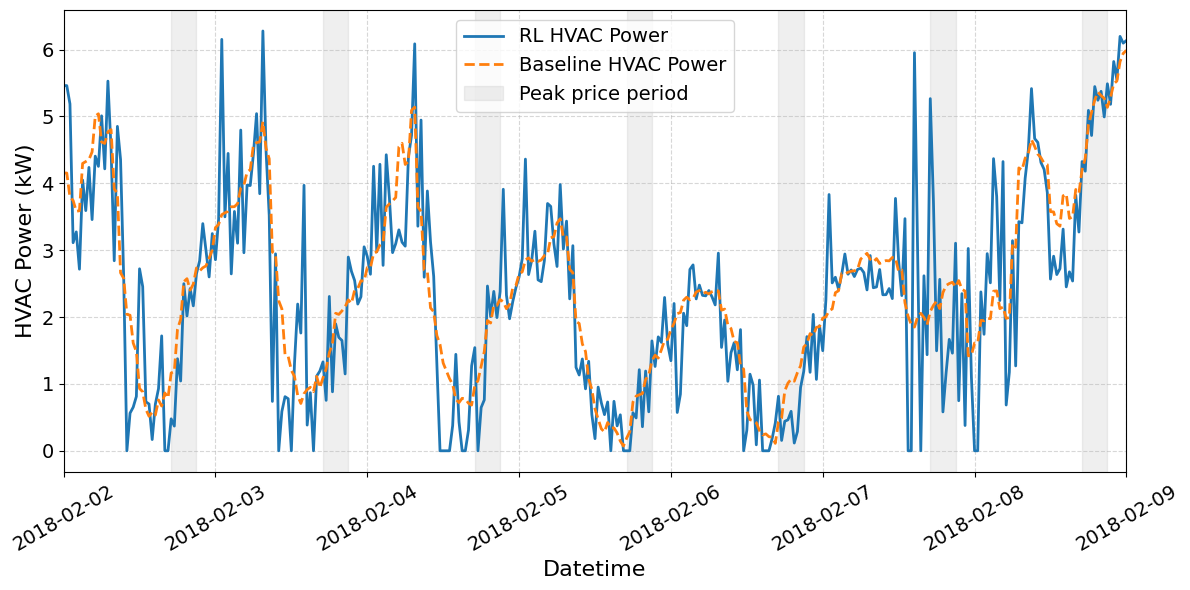

In [47]:
# ===========================
# Figure 4: HVAC Power Consumption (kW) + Key Tracking
# ===========================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _to_float(x):
    if x is None:
        return None
    if isinstance(x, (int, float, np.number)):
        return float(x)
    if isinstance(x, (list, tuple, np.ndarray)) and np.asarray(x).size == 1:
        return float(np.asarray(x).ravel()[0])
    try:
        return float(x)
    except Exception:
        return None

_printed_power_debug = False

def extract_hvac_power_kw_and_key(info, step_minutes=30):
    """
    Return (power_kW, key_used) from env 'info'.
    Tries power keys first; then energy keys (kWh/Wh) converted to average kW over the timestep.
    """
    global _printed_power_debug
    if not isinstance(info, dict):
        return np.nan, None

    # 1) Common direct power keys (kW or W)
    direct_candidates = [
        "HVAC Heating - Power (kW)",
        "HVAC Heating Power (kW)",
        "HVAC - Power (kW)",
        "HVAC Power (kW)",
        "Heating - Power (kW)",
        "Heat Pump - Power (kW)",
        "HVAC Heating - Power (W)",
        "HVAC Heating Power (W)",
        "HVAC - Power (W)",
        "HVAC Power (W)",
        "Heating - Power (W)",
        "Heat Pump - Power (W)",
    ]
    for k in direct_candidates:
        if k in info:
            v = _to_float(info.get(k))
            if v is None:
                continue
            kl = k.lower()
            if "(w" in kl or kl.endswith("w)"):
                return v / 1000.0, k
            return v, k

    # 2) Scan for any key that looks like HVAC/heating power
    for k, v in info.items():
        kl = str(k).lower()
        if ("power" in kl) and (re.search(r"\bhvac\b|heating|heat\s*pump|furnace|aux", kl) is not None):
            vv = _to_float(v)
            if vv is None:
                continue
            # unit heuristic
            if ("kw" in kl):
                return vv, str(k)
            if ("(w" in kl) or re.search(r"\bw\b", kl):
                return vv / 1000.0, str(k)
            # assume kW if unspecified
            return vv, str(k)

    # 3) Energy -> average power over step
    dt_hr = step_minutes / 60.0
    for k, v in info.items():
        kl = str(k).lower()
        if re.search(r"\bhvac\b|heating|heat\s*pump|furnace|aux", kl) is None:
            continue
        if re.search(r"energy|electricity|consumption", kl) is None:
            continue

        ev = _to_float(v)
        if ev is None:
            continue

        if "kwh" in kl:
            return ev / dt_hr, str(k)  # energy key used
        if re.search(r"\bwh\b", kl):
            return (ev / 1000.0) / dt_hr, str(k)  # energy key used

    # Helpful one-time debug if nothing found
    if not _printed_power_debug:
        hvac_like = [k for k in info.keys()
                     if re.search(r"hvac|heating|heat\s*pump|furnace|aux|power|energy", str(k), re.I)]
        if hvac_like:
            print("HVAC/power/energy-related info keys found (for debugging):")
            for k in hvac_like[:50]:
                print("  -", k)
        else:
            print("No HVAC/power/energy-related keys found in info dict.")
        _printed_power_debug = True

    return np.nan, None

def evaluate_policy_power(env, model, max_steps=2000, step_minutes=30, fallback_start="2018-02-01 00:00:00"):
    data = []
    obs, info = env.reset()

    # initial row at 00:00 (no step yet)
    data.append({
        "Datetime": safe_datetime(info, 0, start=fallback_start, minutes=step_minutes),
        "HVACPower_kW": np.nan,
        "HVACPowerKey": None,
    })

    for t in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0:
            raise RuntimeError("Empty action from model.")

        obs, r, terminated, truncated, info = env.step(action)

        p_kw, p_key = extract_hvac_power_kw_and_key(info, step_minutes=step_minutes)

        data.append({
            "Datetime": safe_datetime(info, t + 1, start=fallback_start, minutes=step_minutes),
            "HVACPower_kW": p_kw,
            "HVACPowerKey": p_key,
        })

        if terminated or truncated:
            break

    dfp = pd.DataFrame(data)
    if len(dfp) >= 2 and np.isnan(dfp.loc[0, "HVACPower_kW"]):
        dfp.loc[0, "HVACPower_kW"] = dfp.loc[1, "HVACPower_kW"]
        dfp.loc[0, "HVACPowerKey"] = dfp.loc[1, "HVACPowerKey"]
    return dfp

# Ensure baseline_model exists
try:
    baseline_model
except NameError:
    baseline_model = RealisticThermostat(setpoint=21)

print("Running rollouts for HVAC power...")

# --- minimal: force exactly 7 days @ 30-min resolution ---
max_steps_week = 7 * 24 * 2  # 336
# --------------------------------------------------------

# --- minimal: match the SAME evaluation start as your updated env_feb cell ---
EVAL_START_TIME = "2018-02-02 00:00:00"
# ---------------------------------------------------------------------------

env_feb.reset()
rl_power_df = evaluate_policy_power(
    env_feb, sac_model, max_steps=max_steps_week, step_minutes=30, fallback_start=EVAL_START_TIME
)

env_feb.reset()
base_power_df = evaluate_policy_power(
    env_feb, baseline_model, max_steps=max_steps_week, step_minutes=30, fallback_start=EVAL_START_TIME
)

# Print which key(s) were used
print("\nRL key usage (top):")
print(rl_power_df["HVACPowerKey"].value_counts(dropna=False).head(10))
print("\nBaseline key usage (top):")
print(base_power_df["HVACPowerKey"].value_counts(dropna=False).head(10))

# ---- total energy (kWh) from power (kW) ----
dt_hr = 30 / 60  # 0.5 hours per step (matches time_res)
E_rl_kwh   = np.nansum(rl_power_df["HVACPower_kW"].to_numpy())   * dt_hr
E_base_kwh = np.nansum(base_power_df["HVACPower_kW"].to_numpy()) * dt_hr
print(f"\nRL total HVAC energy: {E_rl_kwh:.2f} kWh")
print(f"Baseline total HVAC energy: {E_base_kwh:.2f} kWh")
print(f"Energy savings (Baseline - RL): {(E_base_kwh - E_rl_kwh):.2f} kWh")

# ---- TOU HVAC energy cost using Price ($/kWh) from rl_df (same env_feb window) ----
price = np.asarray(rl_df["Price"], dtype=float)  # $/kWh
p_rl  = np.asarray(rl_power_df["HVACPower_kW"], dtype=float)
p_b   = np.asarray(base_power_df["HVACPower_kW"], dtype=float)
n = min(price.size, p_rl.size, p_b.size)  # safety alignment
C_rl  = np.nansum(price[:n] * p_rl[:n] * dt_hr)
C_b   = np.nansum(price[:n] * p_b[:n]  * dt_hr)

print(f"\nRL HVAC energy cost (TOU): ${C_rl:.2f}")
print(f"Baseline HVAC energy cost (TOU): ${C_b:.2f}")
print(f"Cost savings (Baseline - RL): ${C_b - C_rl:.2f}")
# ----------------------------------------------------------------------------------

# ===========================
# NEW (minimal): Comfort metrics like the report
# - Preferred-temp RMSE during occupied hours only (18:00–09:00)
# - Optional: degree-hours outside comfort band during occupied hours
# ===========================
# preferred temperature (same as set-point in the report)
Tpref = 21.0

# occupancy mask based on hour-of-day (matches your is_occupied logic)
h = np.asarray(rl_df["Hour"], dtype=float) % 24.0
occ = (h >= 18.0) | (h < 9.0)

tin_rl = np.asarray(rl_df["IndoorTemp_RL"], dtype=float)
tin_b  = np.asarray(base_df["IndoorTemp_RL"], dtype=float)

# Preferred-temp RMSE (occupied only)
rmse_rl = np.sqrt(np.nanmean((tin_rl[occ] - Tpref) ** 2))
rmse_b  = np.sqrt(np.nanmean((tin_b[occ]  - Tpref) ** 2))
print(f"\nPreferred-temp RMSE (occupied only):")
print(f"  RL: {rmse_rl:.2f} °C")
print(f"  Baseline: {rmse_b:.2f} °C")

# Degree-hours outside comfort band (occupied only) - uses your computed comfort bands
cl = np.asarray(comfort_low_series, dtype=float)
ch = np.asarray(comfort_high_series, dtype=float)
below_rl = np.clip(cl - tin_rl, 0, None)
above_rl = np.clip(tin_rl - ch, 0, None)
below_b  = np.clip(cl - tin_b,  0, None)
above_b  = np.clip(tin_b - ch,  0, None)

dh_rl = np.nansum((below_rl[occ] + above_rl[occ]) * dt_hr)
dh_b  = np.nansum((below_b[occ]  + above_b[occ])  * dt_hr)
print(f"\nComfort violation degree-hours (occupied only):")
print(f"  RL: {dh_rl:.2f} °C·h")
print(f"  Baseline: {dh_b:.2f} °C·h")
print(f"  Reduction (Baseline - RL): {(dh_b - dh_rl):.2f} °C·h")
# ===========================

# Plot
plt.figure(figsize=(12, 6))
plt.plot(rl_power_df["Datetime"], rl_power_df["HVACPower_kW"], linewidth=2, label="RL HVAC Power")
plt.plot(base_power_df["Datetime"], base_power_df["HVACPower_kW"], linestyle="--", linewidth=2, label="Baseline HVAC Power")

# Shade peak price hours (17:00–21:00) using RL datetime series
_dt_series = pd.to_datetime(rl_power_df["Datetime"])
_hours_peak = _dt_series.dt.hour + _dt_series.dt.minute / 60.0
_peak_mask = (_hours_peak >= 17.0) & (_hours_peak < 21.0)
_dt_values_peak = _dt_series.to_numpy()
_peak_values = _peak_mask.to_numpy()

_in_peak = False
_peak_start = None
_added_peak_legend = False

for _dt, _peak in zip(_dt_values_peak, _peak_values):
    if _peak and not _in_peak:
        _in_peak = True
        _peak_start = _dt
    elif not _peak and _in_peak:
        if not _added_peak_legend:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0, label="Peak price period")
            _added_peak_legend = True
        else:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0)
        _in_peak = False

if _in_peak and _peak_start is not None:
    if not _added_peak_legend:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0, label="Peak price period")
    else:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0)

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("HVAC Power (kW)", fontsize=16)
plt.xlim(rl_power_df["Datetime"].min(), rl_power_df["Datetime"].max())
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
# -----------------------------------------------------------------------------
# Display Table: Datetime, OCHRE Internal Clock (Hour), Comfort Band Low/High
# plus RL & Baseline setpoints and indoor temps, a single Outdoor Temp, and Price
# -----------------------------------------------------------------------------

comfort_table = pd.DataFrame({
    "Datetime": rl_df["Datetime"],
    "OCHRE_Hour_Obs": rl_df["Hour"],
    "Comfort_Low": comfort_low_series,
    "Comfort_High": comfort_high_series,
    "Outdoor_Temp": rl_df["OutdoorTemp_RL"],
    "Energy_Price": rl_df["Price"],
    "RL_Setpoint": rl_df["Setpoint_RL"],
    "RL_Indoor_Temp": rl_df["IndoorTemp_RL"],
    "Baseline_Setpoint": base_df["Setpoint_RL"],
    "Baseline_Indoor_Temp": base_df["IndoorTemp_RL"],
})

print("=== Comfort Band + RL/Baseline Verification Table (First 50 Steps) ===")
display(comfort_table.head(50))


=== Comfort Band + RL/Baseline Verification Table (First 50 Steps) ===


,Datetime,OCHRE_Hour_Obs,Comfort_Low,Comfort_High,Outdoor_Temp,Energy_Price,RL_Setpoint,RL_Indoor_Temp,Baseline_Setpoint,Baseline_Indoor_Temp
0,2018-02-01 00:00:00,0.0,19.0,23.0,-9.4,0.07,20.813484,20.707196,21.0,20.707196
1,2018-02-01 00:30:00,0.0,19.0,23.0,-6.1,0.07,20.813484,20.891506,21.0,21.078022
2,2018-02-01 01:00:00,0.0,19.0,23.0,-6.5,0.07,20.963705,21.053534,21.0,21.089720
3,2018-02-01 01:30:00,1.0,19.0,23.0,-6.5,0.07,20.951403,21.044927,21.0,21.093600
4,2018-02-01 02:00:00,1.0,19.0,23.0,-6.9,0.07,20.948267,21.043193,21.0,21.094906
5,2018-02-01 02:30:00,2.0,19.0,23.0,-6.9,0.07,20.966972,21.061951,21.0,21.094969
6,2018-02-01 03:00:00,2.0,19.0,23.0,-7.3,0.07,20.700363,20.795515,21.0,21.095151
7,2018-02-01 03:30:00,3.0,19.0,23.0,-7.3,0.07,20.644024,20.739042,21.0,21.094897
8,2018-02-01 04:00:00,3.0,19.0,23.0,-7.8,0.07,20.779905,20.874925,21.0,21.094974
9,2018-02-01 04:30:00,4.0,19.0,23.0,-7.8,0.07,20.678284,20.772952,21.0,21.094684


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Running RL Agent...
Running Baseline...


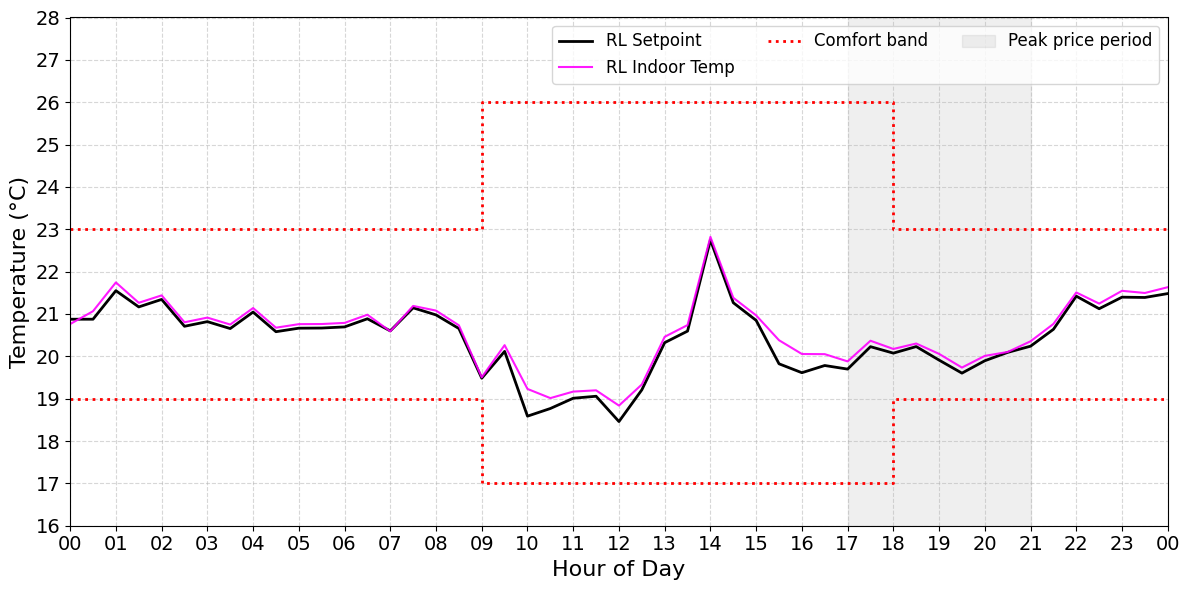

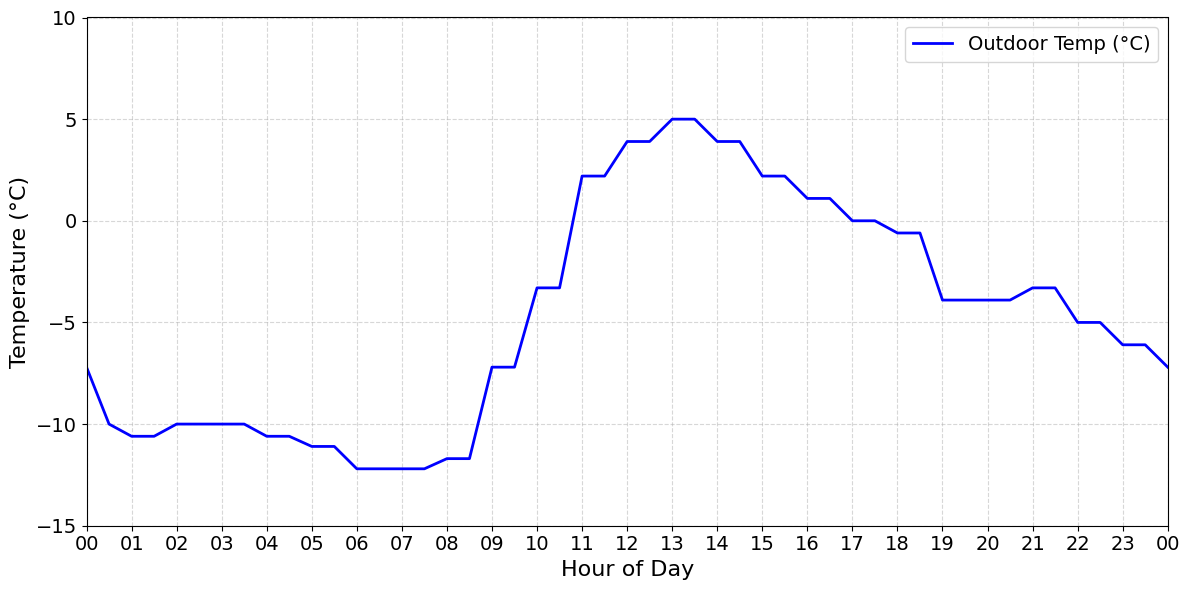

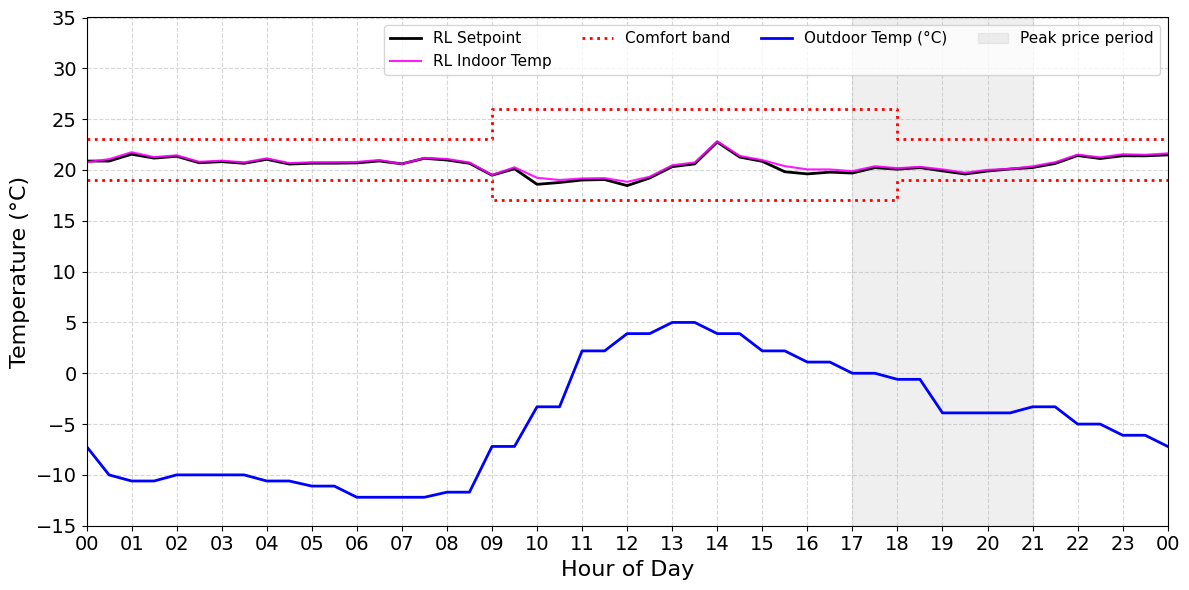

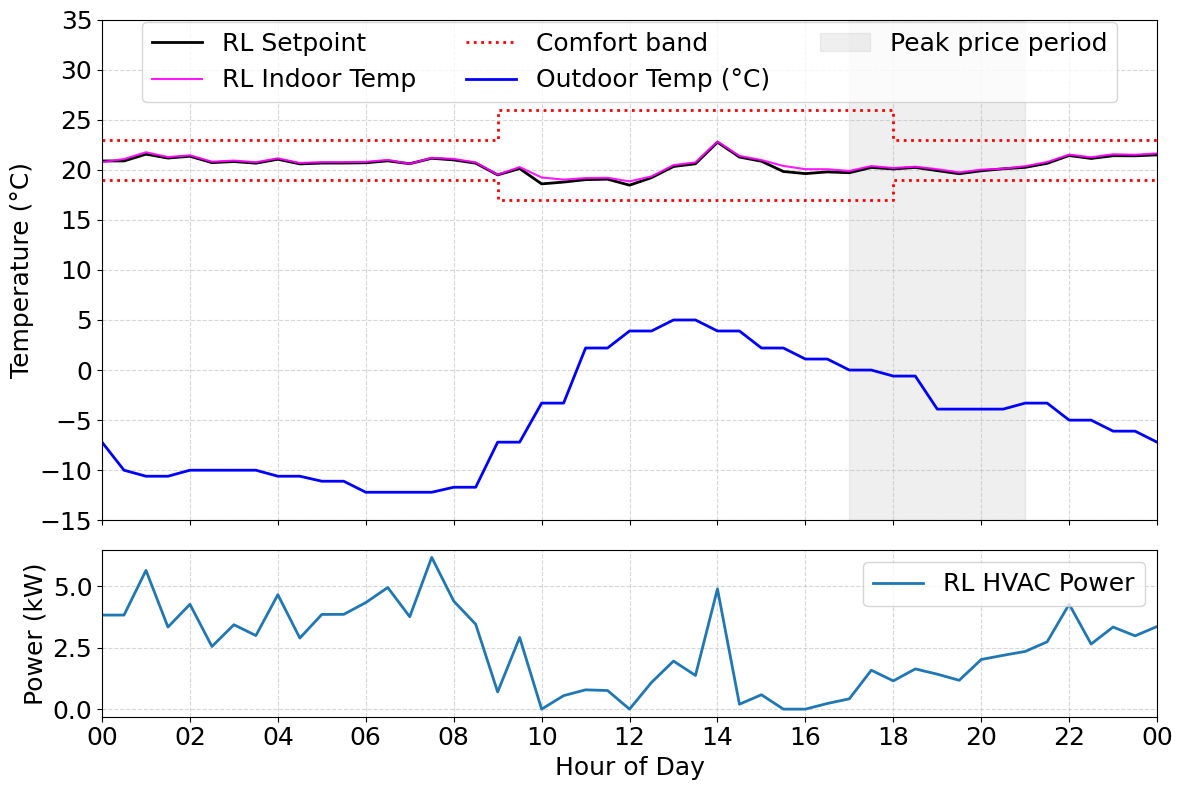

In [52]:
# ===========================
# Helpers
# ===========================
def is_occupied(hour_of_day: float) -> bool:
    """Restoring function to fix TypeError in environment wrapper."""
    h = float(hour_of_day) % 24.0
    return (h >= 18.0) or (h < 9.0)

def safe_datetime(info, t, start="2018-02-01", minutes=30):
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt

def extract_indoor_temp(obs, info):
    # Prefer info dict (ground truth)
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    # Fallback: Index 2 matches sorted OBS_KEYS
    obs = np.asarray(obs).ravel()
    return float(obs[2]) if obs.size >= 3 else np.nan

def extract_outdoor_temp(obs, info):
    # Prefer info dict (ground truth)
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    # Fallback: Index 3 matches sorted OBS_KEYS
    obs = np.asarray(obs).ravel()
    return float(obs[3]) if obs.size >= 4 else np.nan

def extract_obs_components(obs):
    """
    obs[0] = price_now
    obs[1] = hour_now
    obs[2] = T_in_now
    obs[3] = T_out_now
    """
    obs = np.asarray(obs).ravel()
    price = float(obs[0]) if obs.size >= 1 else np.nan
    hour  = float(obs[1]) if obs.size >= 2 else np.nan
    tin   = float(obs[2]) if obs.size >= 3 else np.nan
    tout  = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour

def compute_comfort_bands_from_hour(hours):
    """
    Compute comfort bands based on Ochre's hour observation,
    matching the is_occupied() logic exactly.
    """
    h = np.asarray(hours, dtype=float) % 24.0
    night_mask = (h >= 18.0) | (h < 9.0)
    lows  = np.where(night_mask, 19.0, 17.0)
    highs = np.where(night_mask, 23.0, 26.0)
    return lows, highs


# ===========================
# Baseline Controller
# ===========================
class RealisticThermostat:
    def __init__(self, setpoint=21):
        self.setpoint = np.array([setpoint], dtype=np.float32)

    def predict(self, obs, deterministic=True):
        return self.setpoint, None


# ===========================
# Evaluation Function (1-day evaluation)
# ===========================
def evaluate_policy_with_actions_1day(env, model, max_steps=2000):
    data = []
    obs, info = env.reset()

    # ---- initial pre-step state at 00:00 ----
    tin0, tout0, price0, hour0 = extract_obs_components(obs)
    data.append({
        "Datetime": safe_datetime(info, 0),
        "Setpoint_RL": np.nan,  # no action applied yet
        "IndoorTemp_RL": extract_indoor_temp(obs, info),
        "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
        "Tout": tout0,
        "Price": price0,
        "Hour": hour0,
    })

    for t in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0:
            raise RuntimeError("Empty action from model.")
        sp = float(action[0])

        obs, r, terminated, truncated, info = env.step(action)
        tin, tout, price, hour = extract_obs_components(obs)

        data.append({
            # use t+1 so fallback time is 00:30, 01:00, ... after the 00:00 row
            "Datetime": safe_datetime(info, t + 1),
            "Setpoint_RL": sp,
            "IndoorTemp_RL": extract_indoor_temp(obs, info),
            "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
            "Tout": tout,
            "Price": price,
            "Hour": hour,
        })

        if terminated or truncated:
            break

    df = pd.DataFrame(data)

    if len(df) >= 2 and np.isnan(df.loc[0, "Setpoint_RL"]):
        df.loc[0, "Setpoint_RL"] = df.loc[1, "Setpoint_RL"]

    return df


# ===========================
# Evaluation Env (UPDATED CONFIG)
# ===========================
def make_eval_env(
    start_time: str = "2018-02-3 00:00:00",
    episode_duration: str = "1 days",
):
    """Create an evaluation env for a given start time and episode duration.
    Defaults give a 1-day February evaluation window starting Feb 10.
    """
    base = make_env(start_time, episode_duration)
    base = VariableComfortRewardWrapper(
        base,
        comfort_unit_penalty=50.0,
        reward_scale=0.1,
        energy_cost_multiplier=12.0,
        preferred_temp=21.0,
        preferred_temp_weight=5.0,
    )
    base = ForecastObsWrapper(
        base,
        start_time=start_time,
        episode_duration=episode_duration,
        horizon_hours=12.0,
        time_res_minutes=30,
    )
    return base

# Default: 1-day evaluation window
env_feb = make_eval_env()

# ===========================
# Run Simulations
# ===========================
print("Running RL Agent...")
env_feb.reset()
rl_df = evaluate_policy_with_actions_1day(env_feb, sac_model)

print("Running Baseline...")
env_feb.reset()
baseline_model = RealisticThermostat(setpoint=21)
base_df = evaluate_policy_with_actions_1day(env_feb, baseline_model)

# Compute time-varying comfort bands based on Datetime
comfort_low_series, comfort_high_series = compute_comfort_bands_from_hour(
    rl_df["Hour"]
)

# ===========================
# Figure 1: Indoor Temperature Comparison
# ===========================
plt.figure(figsize=(12, 6))

# RL Plots
plt.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
plt.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

# Baseline Plots
# plt.plot(base_df["Datetime"], base_df["Setpoint_RL"], color="black", linestyle="--", linewidth=2, label="Baseline Setpoint (21°C)")
# plt.plot(base_df["Datetime"], base_df["IndoorTemp_RL"], color="magenta", linestyle="--", alpha=0.9, linewidth=1.5, label="Baseline Indoor Temp")

# Comfort Bands (STEP PLOTS)
plt.step(
    rl_df["Datetime"],
    comfort_low_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
    label="Comfort band",
)
plt.step(
    rl_df["Datetime"],
    comfort_high_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
)

# Highlight peak price hours (17:00–21:00) as a grey region
_dt_series = pd.to_datetime(rl_df["Datetime"])
_hours_peak = _dt_series.dt.hour + _dt_series.dt.minute / 60.0
_peak_mask = (_hours_peak >= 17.0) & (_hours_peak < 21.0)
_dt_values_peak = _dt_series.to_numpy()
_peak_values = _peak_mask.to_numpy()

_in_peak = False
_peak_start = None
_added_peak_legend = False

for _dt, _peak in zip(_dt_values_peak, _peak_values):
    if _peak and not _in_peak:
        _in_peak = True
        _peak_start = _dt
    elif not _peak and _in_peak:
        # End the peak interval at the start of the first non-peak time
        if not _added_peak_legend:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0, label="Peak price period")
            _added_peak_legend = True
        else:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0)
        _in_peak = False

# If the last timestep is still in peak hours, shade until the final timestamp
if _in_peak and _peak_start is not None:
    if not _added_peak_legend:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0, label="Peak price period")
    else:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0)

plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.ylim(16, 28)
plt.yticks(np.arange(16, 29, 1), fontsize=14)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
ax1 = plt.gca()
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
plt.legend(loc='upper right', ncol=3, fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

# ===========================
# Figure 2: Outdoor Temperature
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.ylim(-15, 10)
plt.yticks(np.arange(-15, 11, 5))
ax2 = plt.gca()
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# ===========================
# Figure 3: Combined Indoor & Outdoor Temperature
# ===========================
plt.figure(figsize=(12, 6))

# RL and Baseline setpoints and indoor temps
plt.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
plt.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

# plt.plot(base_df["Datetime"], base_df["Setpoint_RL"], color="black", linestyle="--", linewidth=2, label="Baseline Setpoint (21°C)")
# plt.plot(base_df["Datetime"], base_df["IndoorTemp_RL"], color="magenta", linestyle="--", alpha=0.9, linewidth=1.5, label="Baseline Indoor Temp")

# Comfort bands
plt.step(
    rl_df["Datetime"],
    comfort_low_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
    label="Comfort band",
)
plt.step(
    rl_df["Datetime"],
    comfort_high_series,
    where="pre",
    color="red",
    linestyle=":",
    linewidth=2,
)

# Outdoor temperature
plt.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

# Grey peak price region (reuse same logic)
_dt_series = pd.to_datetime(rl_df["Datetime"])
_hours_peak = _dt_series.dt.hour + _dt_series.dt.minute / 60.0
_peak_mask = (_hours_peak >= 17.0) & (_hours_peak < 21.0)
_dt_values_peak = _dt_series.to_numpy()
_peak_values = _peak_mask.to_numpy()

_in_peak = False
_peak_start = None
_added_peak_legend = False

for _dt, _peak in zip(_dt_values_peak, _peak_values):
    if _peak and not _in_peak:
        _in_peak = True
        _peak_start = _dt
    elif not _peak and _in_peak:
        if not _added_peak_legend:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0, label="Peak price period")
            _added_peak_legend = True
        else:
            plt.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0)
        _in_peak = False

if _in_peak and _peak_start is not None:
    if not _added_peak_legend:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0, label="Peak price period")
    else:
        plt.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0)

plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.ylim(-15, 35)
plt.yticks(np.arange(-15, 36, 5), fontsize=14)
ax3 = plt.gca()
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(fontsize=14)
plt.legend(loc='upper right', ncol=4, fontsize=11)
plt.tight_layout()
plt.show()

# ===========================
# Figure 4: Figure 3 (top) + HVAC Power (bottom)
# ===========================
# (minimal add: compute HVAC power from info, then stack plots)

def _to_float(x):
    if x is None:
        return None
    if isinstance(x, (int, float, np.number)):
        return float(x)
    if isinstance(x, (list, tuple, np.ndarray)) and np.asarray(x).size == 1:
        return float(np.asarray(x).ravel()[0])
    try:
        return float(x)
    except Exception:
        return None

def _extract_hvac_power_kw(info):
    # Prefer the key we already observed in your runs
    if isinstance(info, dict) and ("HVAC Heating Electric Power (kW)" in info):
        v = _to_float(info.get("HVAC Heating Electric Power (kW)"))
        return np.nan if v is None else float(v)
    # Fallback: generic scan
    if not isinstance(info, dict):
        return np.nan
    for k, v in info.items():
        kl = str(k).lower()
        if ("power" in kl) and (re.search(r"\bhvac\b|heating|heat\s*pump|furnace|aux", kl) is not None):
            vv = _to_float(v)
            if vv is None:
                continue
            if "kw" in kl:
                return float(vv)
            if "(w" in kl or re.search(r"\bw\b", kl):
                return float(vv) / 1000.0
            return float(vv)
    return np.nan

def evaluate_hvac_power_1day(env, model, max_steps=2000):
    data = []
    obs, info = env.reset()

    data.append({
        "Datetime": safe_datetime(info, 0),
        "HVACPower_kW": np.nan,
    })

    for t in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0:
            raise RuntimeError("Empty action from model.")

        obs, r, terminated, truncated, info = env.step(action)

        data.append({
            "Datetime": safe_datetime(info, t + 1),
            "HVACPower_kW": _extract_hvac_power_kw(info),
        })

        if terminated or truncated:
            break

    dfp = pd.DataFrame(data)
    if len(dfp) >= 2 and np.isnan(dfp.loc[0, "HVACPower_kW"]):
        dfp.loc[0, "HVACPower_kW"] = dfp.loc[1, "HVACPower_kW"]
    return dfp

env_feb.reset()
rl_pwr = evaluate_hvac_power_1day(env_feb, sac_model)

env_feb.reset()
base_pwr = evaluate_hvac_power_1day(env_feb, baseline_model)




fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

# ---- TOP: reproduce Figure 3 as-is (same colors/styles) ----
ax_top.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
ax_top.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

ax_top.step(rl_df["Datetime"], comfort_low_series, where="pre", color="red", linestyle=":", linewidth=2, label="Comfort band")
ax_top.step(rl_df["Datetime"], comfort_high_series, where="pre", color="red", linestyle=":", linewidth=2)

ax_top.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

# Grey peak price region (same logic)
_dt_series = pd.to_datetime(rl_df["Datetime"])
_hours_peak = _dt_series.dt.hour + _dt_series.dt.minute / 60.0
_peak_mask = (_hours_peak >= 17.0) & (_hours_peak < 21.0)
_dt_values_peak = _dt_series.to_numpy()
_peak_values = _peak_mask.to_numpy()

_in_peak = False
_peak_start = None
_added_peak_legend = False

for _dt, _peak in zip(_dt_values_peak, _peak_values):
    if _peak and not _in_peak:
        _in_peak = True
        _peak_start = _dt
    elif not _peak and _in_peak:
        if not _added_peak_legend:
            ax_top.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0, label="Peak price period")
            _added_peak_legend = True
        else:
            ax_top.axvspan(_peak_start, _dt, color="grey", alpha=0.12, zorder=0)
        _in_peak = False

if _in_peak and _peak_start is not None:
    if not _added_peak_legend:
        ax_top.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0, label="Peak price period")
    else:
        ax_top.axvspan(_peak_start, _dt_values_peak[-1], color="grey", alpha=0.12, zorder=0)

ax_top.set_ylabel("Temperature (°C)", fontsize=18)          # <-- minimal: bigger
ax_top.set_ylim(-15, 35)
ax_top.set_yticks(np.arange(-15, 36, 5))
ax_top.grid(True, linestyle="--", alpha=0.5)
ax_top.tick_params(axis="both", labelsize=18)              # <-- minimal: bigger ticks

# <-- minimal: 5 columns, single row
ax_top.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=18)

# ---- BOTTOM: HVAC power ----
ax_bot.plot(rl_pwr["Datetime"], rl_pwr["HVACPower_kW"], linewidth=2, label="RL HVAC Power")
ax_bot.set_ylabel("Power (kW)", fontsize=18)               # <-- minimal: bigger
ax_bot.grid(True, linestyle="--", alpha=0.5)
ax_bot.tick_params(axis="both", labelsize=18)              # <-- minimal: bigger ticks
ax_bot.legend(loc="upper right", fontsize=18)

# shared x formatting
ax_bot.set_xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
ax_bot.xaxis.set_major_locator(mdates.HourLocator(interval=2))   # <-- minimal: 2-hour increments
ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax_bot.set_xlabel("Hour of Day", fontsize=18)              # <-- minimal: bigger

plt.tight_layout()
plt.show()


In [13]:
# ===== Debug: check occupancy + comfort bands over the day =====
# Uses the helpers already defined in the previous cell.

# 1) Occupancy flag from the same logic used in the wrapper
rl_df["Occupied_flag"] = rl_df["Hour"].apply(is_occupied)

# 2) Comfort bands from hour-of-day
low, high = compute_comfort_bands_from_hour(rl_df["Hour"].values)
rl_df["ComfortLow_dbg"] = low
rl_df["ComfortHigh_dbg"] = high

# Look at the first 48 half-hour steps (= first day)
rl_df[["Datetime",
       "Hour",
       "Occupied_flag",
       "ComfortLow_dbg",
       "ComfortHigh_dbg"]].head(48)


,Datetime,Hour,Occupied_flag,ComfortLow_dbg,ComfortHigh_dbg
0,2018-02-01 00:00:00,0.0,True,19.0,23.0
1,2018-02-01 00:30:00,0.0,True,19.0,23.0
2,2018-02-01 01:00:00,0.0,True,19.0,23.0
3,2018-02-01 01:30:00,1.0,True,19.0,23.0
4,2018-02-01 02:00:00,1.0,True,19.0,23.0
5,2018-02-01 02:30:00,2.0,True,19.0,23.0
6,2018-02-01 03:00:00,2.0,True,19.0,23.0
7,2018-02-01 03:30:00,3.0,True,19.0,23.0
8,2018-02-01 04:00:00,3.0,True,19.0,23.0
9,2018-02-01 04:30:00,4.0,True,19.0,23.0


In [14]:
# Create a simple evaluation environment (1-day episode)
env = make_env("2018-02-01 00:00:00", "1 days")

# Print the full action space object
print("Action Space:", env.action_space)

# Print the specific minimum and maximum values
print("Minimum Allowed Setpoint:", env.action_space.low)
print("Maximum Allowed Setpoint:", env.action_space.high)

env.close()

Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Action Space: Box(18.0, 35.0, (1,), float32)
Minimum Allowed Setpoint: [18.]
Maximum Allowed Setpoint: [35.]
